In [9]:
import pandas as pd


def format_pd(data, intento):

    data = data[data["Intento"] == intento].copy() 

    # Esto es para que arranque en 365 una vez (lo hizo chat obviamente)
    mask = (data['x'] != 365.00) | (data['x'].shift(-1) != 365.00)

    data = data[mask]

    # Arranca en t = 0
    data["t"] = data["t"] - data["t"].min()

    data = data.drop(columns=["Intento"])
    
    return data

C:\Users\valen\AppData\Local\Temp\ipykernel_10636\2901196611.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(t_ajuste, modelo_cuadratico(t_ajuste, *popt), 'r', color = 'black')
C:\Users\valen\AppData\Local\Temp\ipykernel_10636\2901196611.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(t_ajuste, modelo_cuadratico(t_ajuste, *popt), 'r', color = 'black')


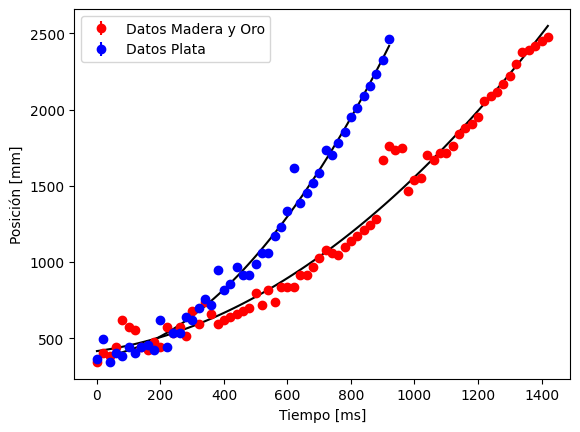

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

datasets = [('data_maderayoro_dosplata.csv', 'r'), ('data_plata_dosplata.csv', 'b')] 

for dataset, color in datasets:
    if datasets.index((dataset, color)) == 0:
        name = "Madera y Oro"
    else:
        name = "Plata"
    data = pd.read_csv(dataset)

    f_data = format_pd(data=data, intento=1)


    tiempo = f_data["t"].values
    posicion = f_data["x"].values
    errores_y =  1
    errores_x = 1


    # Definir la función cuadrática con v_0 = 0
    def modelo_cuadratico(t, a, v_0, x_0):
        return a * t**2 + v_0 * t +  x_0

    # Ajustar la curva
    popt, pcov = curve_fit(modelo_cuadratico, tiempo, posicion, sigma=errores_y, absolute_sigma=True)

    # Obtener los coeficientes ajustados y sus errores
    a_opt, v_0_opt, x_0_opt = popt
    errores = np.sqrt(np.diag(pcov))

    # Graficar los datos y el ajuste
    t_ajuste = np.linspace(tiempo.min(), tiempo.max(), 100)
    plt.errorbar(tiempo, posicion, yerr=errores_y, fmt='o', label=f'Datos {name}', color = color)

    plt.plot(t_ajuste, modelo_cuadratico(t_ajuste, *popt), 'r', color = 'black')

plt.xlabel('Tiempo [ms]')
plt.ylabel('Posición [mm]')
plt.legend()
plt.show()


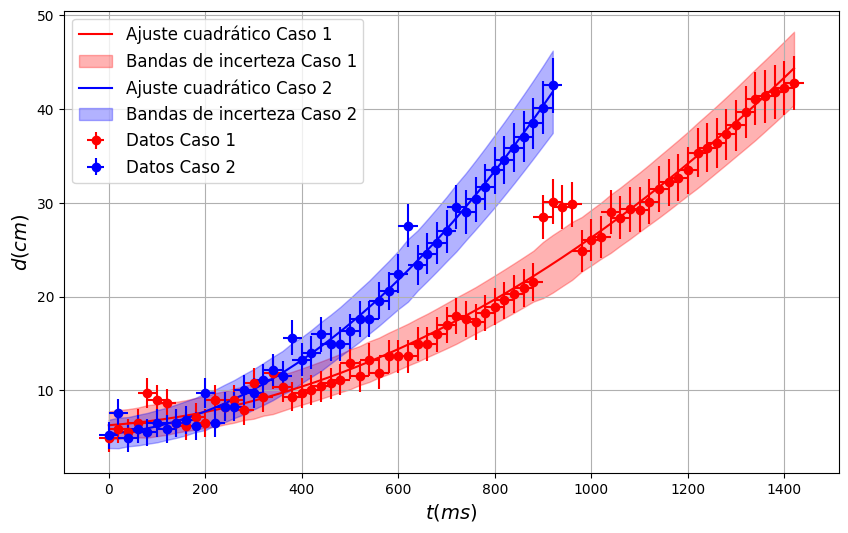


Parámetros del ajuste cuadrático para Caso 1:
a = 0.000038 ± 0.000004
b = 0.004311 ± 0.003717
c = 5.374784 ± 0.643439

Parámetros del ajuste cuadrático para Caso 2:
a = 0.000038 ± 0.000004
b = 0.004311 ± 0.003717
c = 5.374784 ± 0.643439


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

# Define the quadratic model
def modelo_cuadratico(t, a, b, c):
    return a * t**2 + b * t + c

# Calibración functions
def distancia(v):
    return 0.0178*v - 1.2753

def sigma_d(v):
    return 0.0007*v + 1.1673

# Error propagation function
def f_propagacion_errores(t, popt, errores_x):
    a, b, c = popt
    sigma_d_t = np.sqrt((2 * a * t + b) ** 2 * errores_x ** 2)
    return sigma_d_t

# List of datasets with m and M values and their corresponding colors
datasets = [
    { "file" : 'data_maderayoro_dosplata.csv', "m" : 110 + 6 + 72, "M" : 2 * 23, "color": "red", "label": "m_1 vs M_1" },
    { "file" : 'data_plata_dosplata.csv', "m" : 110 + 23, "M" : 2 * 23, "color": "blue", "label": "m_2 vs M_2" }
]

plt.figure(figsize=(10, 6))

for dataset in datasets:
    # Load and format data
    data = pd.read_csv(dataset["file"])
    f_data = format_pd(data=data, intento=1)

    # Extract time and position data
    tiempo = f_data["t"].values
    posicion = distancia(f_data["x"].values)
    errores_y = sigma_d(f_data["x"].values)
    errores_x = np.full_like(tiempo, 20)  # Assuming a constant error in time

    # Fit the quadratic model to the data
    popt, pcov = curve_fit(modelo_cuadratico, tiempo, posicion, sigma=errores_y, absolute_sigma=True)

    # Extract the fitted parameters and their uncertainties
    a, b, c = popt
    errores = np.sqrt(np.diag(pcov))

    # Propagate errors
    sigma_d_t = f_propagacion_errores(tiempo, popt, errores_x)

    # Create a smoother time range for plotting the fitted curve
    t_ajuste = np.linspace(min(tiempo), max(tiempo), 500)

    # Use predefined labels for each dataset
    label = dataset["label"]

    # Plot the data points with error bars
    plt.errorbar(tiempo, posicion, xerr=errores_x, yerr=errores_y, fmt='o', color=dataset["color"], label=f'Datos {label}')

    # Plot the quadratic fit
    plt.plot(t_ajuste, modelo_cuadratico(t_ajuste, *popt), color=dataset["color"], linestyle='-', label=f'Ajuste cuadrático {label}')

    # Plot the uncertainty bands
    plt.fill_between(tiempo, 
                     modelo_cuadratico(tiempo, *popt) + sigma_d_t + errores_y, 
                     modelo_cuadratico(tiempo, *popt) - sigma_d_t - errores_y, 
                     color=dataset["color"], alpha=0.3, label=f'Bandas de incerteza {label}')

# Customize the plot
plt.xlabel(r'$t(ms)$', fontsize=14)
plt.ylabel(r'$d(cm)$', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Display the plot
plt.show()

# Print the fitted parameters and their uncertainties for each dataset
for dataset in datasets:
    print(f'\nParámetros del ajuste cuadrático para {dataset["label"]}:')
    print(f'a = {popt[0]:.6f} ± {errores[0]:.6f}')
    print(f'b = {popt[1]:.6f} ± {errores[1]:.6f}')
    print(f'c = {popt[2]:.6f} ± {errores[2]:.6f}')
